# Setup and Imports

In [2]:
!pip install rasterio albumentations

In [3]:
!pip install segmentation-models-pytorch

In [4]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio

In [5]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import albumentations as A

In [7]:
import segmentation_models_pytorch as smp

In [8]:
from google.colab import drive



---


# Reading the dataset

## Mount Google Drive

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extract Zip File

In [10]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 3: Satellite Images Flooding Segmentation/satalite data-20250918T154859Z-1-001.zip'
extract_to = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

## Define Directory Paths

In [11]:
images_dir = os.path.join(extract_to, 'satalite data/data/images')
labels_dir = os.path.join(extract_to, 'satalite data/data/labels')

## **Function to Get Matched Image-Mask Pairs

In [12]:
def get_matched_pairs(images_dir, labels_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
    pairs = []
    for img_file in image_files:
        stem = os.path.splitext(img_file)[0]
        mask_path = os.path.join(labels_dir, stem + '.png')
        if os.path.exists(mask_path):
            pairs.append((os.path.join(images_dir, img_file), mask_path))
    return pairs

In [13]:
pairs = get_matched_pairs(images_dir, labels_dir)
print(f"Found {len(pairs)} matched pairs.")

Found 306 matched pairs.


---

# Dataset Preprocessing

## Split into Train and Test Pairs

In [14]:
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

## Function to Load Multispectral Image

In [15]:
def load_image(path):
    with rasterio.open(path) as src:
        img = src.read()  # Shape: (12, 128, 128)
        img = img.astype(np.float32)
    return img

## Function to Load Binary Mask

In [16]:
def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.float32)  # Binary 0/1
    return mask

## Compute Min-Max for Normalization (Per Channel)

In [17]:
def compute_min_max(train_pairs):
    mins = np.full(12, np.inf)
    maxs = np.full(12, -np.inf)
    for img_path, _ in train_pairs:
        img = load_image(img_path)
        channel_mins = np.min(img, axis=(1, 2))
        channel_maxs = np.max(img, axis=(1, 2))
        mins = np.minimum(mins, channel_mins)
        maxs = np.maximum(maxs, channel_maxs)
    return mins, maxs

In [18]:
mins, maxs = compute_min_max(train_pairs)

# Save mins and maxs for deployment
np.save('mins.npy', mins)
np.save('maxs.npy', maxs)

print("Mins and maxs computed and saved.")

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Mins and maxs computed and saved.


In [19]:
print("Min values:", mins)
print("Max values:", maxs)

Min values: [-1.390e+03 -1.169e+03 -7.220e+02 -6.840e+02 -4.120e+02 -3.350e+02
 -2.510e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]
Max values: [ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  2784.  2762.
   100.   107.]




---



### E:

### Notes:

**I didn't use sklearn's MinMaxScaler primarily because the normalization needed here is a simple per-channel min-max scaling across the entire dataset, which can be efficiently implemented manually with NumPy operations without the overhead of reshaping the 3D image arrays (channels x height x width) into a 2D format that sklearn expects for fitting and transforming.**

**This keeps the code lightweight and avoids unnecessary library dependencies for such a basic arithmetic operation, while still achieving the exact same result as MinMaxScaler would provide if adapted for channel-wise use.**



---



## Function to Normalize Image (Min-Max Scaling)

In [20]:
def normalize_image(img, mins, maxs):
    for c in range(12):
        img[c] = (img[c] - mins[c]) / (maxs[c] - mins[c] + 1e-6)
    return img

## Loading, Normalizing and Visualization of Bands for a Sample Image

In [21]:
def visualize_bands(img_path, mins, maxs):
    img = load_image(img_path)
    img = normalize_image(img, mins, maxs)
    bands = [
        'Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2',
        'QA Band', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability'
    ]
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(img[i], cmap='gray')
        ax.set_title(bands[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

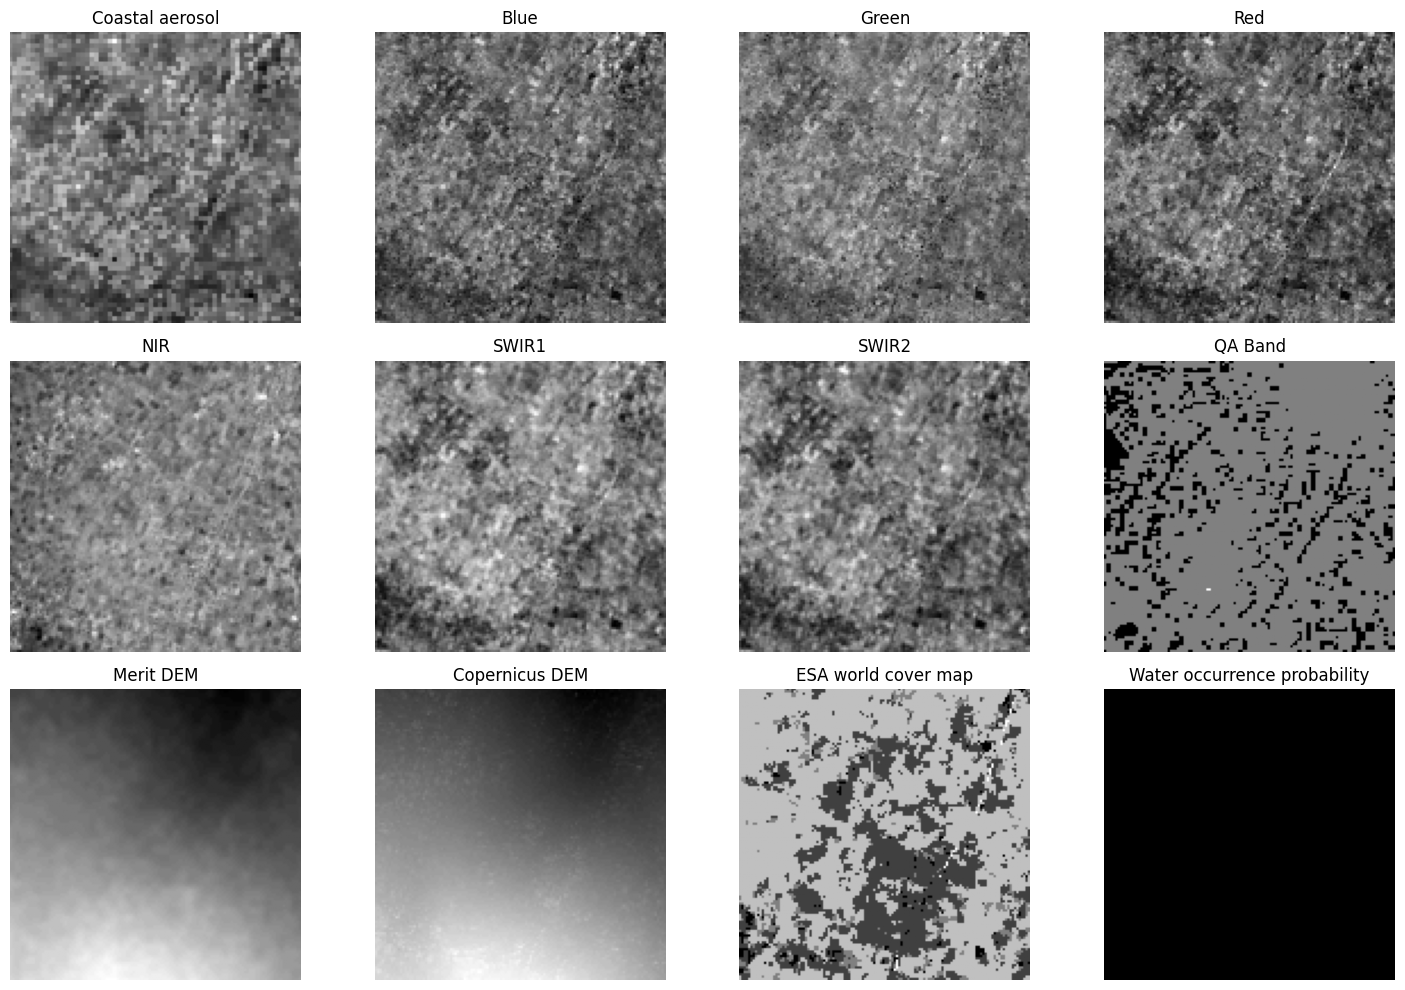

In [22]:
# Example: Visualize the first image
if train_pairs:
    visualize_bands(train_pairs[0][0], mins, maxs)

## Function to Compute Water Indices (Feature Engineering)

In [23]:
def compute_water_indices(img):
    # Channel indices based on diagram: 0: Coastal, 1: Blue, 2: Green, 3: Red, 4: NIR, 5: SWIR1, 6: SWIR2, ...
    green = img[2]
    nir = img[4]
    swir1 = img[5]
    swir2 = img[6]
    ndwi = (green - nir) / (green + nir + 1e-6)
    mndwi = (green - swir1) / (green + swir1 + 1e-6)
    awei = 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)
    indices = np.stack([ndwi, mndwi, awei], axis=0)
    img_with_indices = np.concatenate([img, indices], axis=0)  # Now (15, 128, 128)
    return img_with_indices

### Notes:

* (`NDWI`, `MNDWI`, `AWEI_SH`, `AWEI_NSH`, `NDVI`) are useful (two more than the ones I have above)

* I also included `awei` which isn't on the list above.

1. `NDWI` – **Normalized Difference Water Index**

* **Idea**: Water absorbs strongly in NIR, reflects in Green. So water → high positive NDWI, vegetation/soil → low or negative NDWI.

* **Benefit**: Helps model distinguish water from vegetation/soil where reflectance looks similar in RGB.

2. `MNDWI` - **Modified NDWI**

* **Idea**: Replaces NIR with SWIR, because SWIR is even more absorbed by water.

* **Benefit**: Suppresses built-up land and dark features (roads, shadows) that NDWI sometimes confuses as water.

3. `NDVI` - **Normalized Difference Vegetation Index**

* **Idea**: Vegetation reflects strongly in NIR, absorbs Red.

* **Benefit**: Separates vegetation from water and shadows. Even though it's not a water index, it gives the model “anti-water” info.

4. `AWEI_SH` - **Automated Water Extraction Index (Shadow version)**

* **Idea**: Targets shadowed regions, which NDWI/MNDWI confuse with water.

* **Benefit**: Reduces false positives from mountain/shadow areas.

5. `AWEI_NSH` - **Automated Water Extraction Index (Non-shadow version)**

* **Idea**: Optimized for non-shadow areas, where urban features confuse NDWI.

* **Benefit**: Helps in cities/built-up areas where water and asphalt look similar.

6. `AWEI` - **Automated Water Extraction Index**

This is what I have above in the code, it matches the AWEI_SH (shadow version).

from the original paper by Xu.

**AWEI shadow:**

idx["AWEI_SH"] = 4*(g - s1) - (0.25*n + 2.75*s2)

**AWEI non-shadow:**

idx["AWEI_NSH"] = g - (r + 2.5*n + 1.5*s1 + 0.25*s2)

## Function to Get Feature Importances Using Random Forest

In [24]:
def get_feature_importances(train_pairs, mins, maxs, sample_frac=0.01):
    data_list = []
    label_list = []
    feature_names = [
        'Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2',
        'QA Band', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability',
        'NDWI', 'MNDWI', 'AWEI'
    ]
    for img_path, mask_path in train_pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        img = compute_water_indices(img)  # (15, 128, 128)
        mask = load_mask(mask_path)
        flat_img = img.reshape(15, -1).T  # (16384, 15)
        flat_mask = mask.flatten()  # (16384,)
        num_samples = int(len(flat_mask) * sample_frac)
        indices = np.random.choice(len(flat_mask), num_samples, replace=False)
        data_list.append(flat_img[indices])
        label_list.append(flat_mask[indices])
    data = np.vstack(data_list)
    labels = np.hstack(label_list)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(data, labels)
    importances = clf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    for idx in sorted_indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    # Return top features (e.g., all for now)
    return feature_names, importances

In [25]:
# Compute and print feature importances
feature_names, importances = get_feature_importances(train_pairs, mins, maxs)

NDWI: 0.1821
MNDWI: 0.1523
AWEI: 0.1177
NIR: 0.1098
SWIR1: 0.0629
Merit DEM: 0.0602
SWIR2: 0.0544
Copernicus DEM: 0.0505
Water occurrence probability: 0.0486
Red: 0.0306
Green: 0.0299
ESA world cover map: 0.0298
Coastal aerosol: 0.0285
Blue: 0.0274
QA Band: 0.0154


## Load Training and Testing Data

In [26]:
def load_dataset(pairs, mins, maxs, use_indices=True):
    images = []
    masks = []
    for img_path, mask_path in pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)   # normalization
        if use_indices:
            img = compute_water_indices(img)  # Use 15 channels if True
        mask = load_mask(mask_path)
        images.append(img)
        masks.append(mask)
    return np.stack(images), np.stack(masks)

In [27]:
# Load with indices (15 channels)
num_channels = 15
train_images, train_masks = load_dataset(train_pairs, mins, maxs, use_indices=True)
test_images, test_masks = load_dataset(test_pairs, mins, maxs, use_indices=True)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


## Function to Visualize Random Images in RGB Format

In [28]:
def visualize_random_rgb(images, num_samples=3):
    # Ensure images are in channel-first format (C, H, W) and select random indices
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

    for idx, ax in zip(indices, axs):
        # Use bands 3 (Red), 2 (Green), 1 (Blue) for RGB approximation
        # Transpose to (H, W, C) and select RGB bands
        rgb = images[idx][[3, 2, 1]]  # Shape: (3, 128, 128)
        rgb = np.transpose(rgb, (1, 2, 0))  # Shape: (128, 128, 3)
        rgb = np.clip(rgb, 0, 1)  # Ensure values are in [0, 1] for display
        ax.imshow(rgb)
        ax.set_title(f'Image {idx} (RGB approx)')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

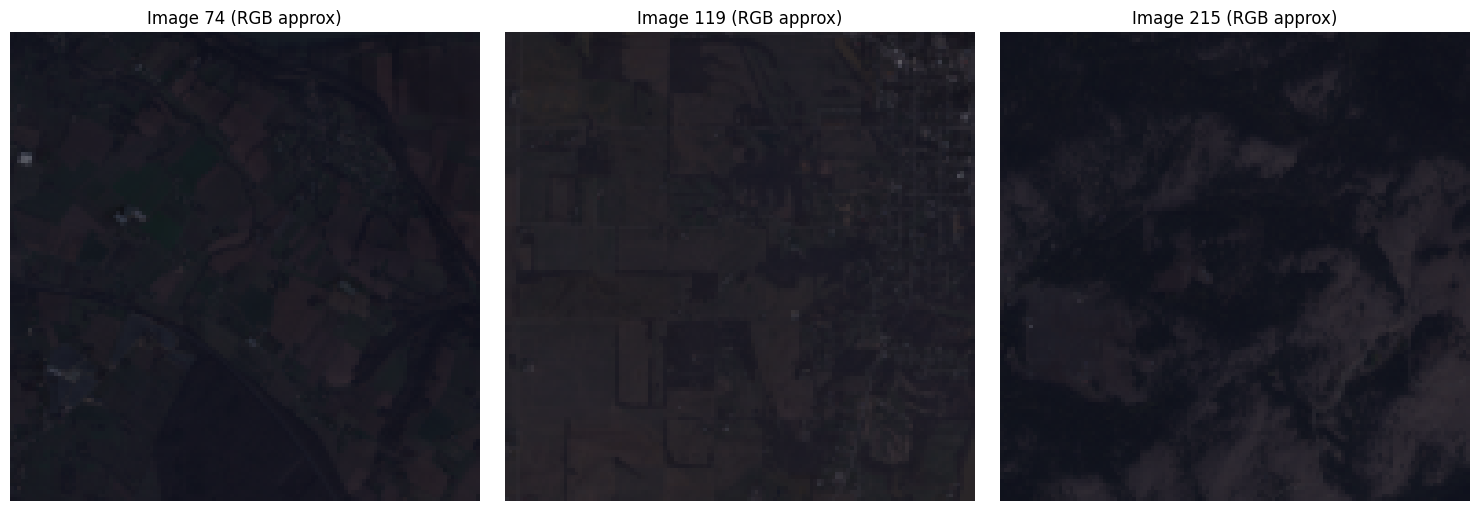

In [29]:
# Visualize random RGB images from training set before augmentation
visualize_random_rgb(train_images)

## Data Augmentation Using Albumentations

In [30]:
def augment_data(images, masks, num_augs=3):
    transform = A.Compose([
        #A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        # A.GaussNoise(p=0.3),

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=0.1, contrast_limit=0.1),

        # A.RandomFlip(p=0.5),
        # A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),   # mild noise
        # A.GaussNoise(std_range=(0.05, 0.1), mean_range=(0.0,0.0), p=0.2),   # mild noise
        A.GaussianBlur(blur_limit=2, p=0.2),          # small blur

        A.GridDistortion(distort_limit=0.05, p=0.2),  # small safe distortion
    ])
    aug_images = list(images)
    aug_masks = list(masks)
    for i in range(len(images)):
        for _ in range(num_augs):
            transposed_img = images[i].transpose(1, 2, 0)  # (128, 128, C)
            tr = transform(image=transposed_img, mask=masks[i])
            aug_img = tr['image'].transpose(2, 0, 1)  # Back to (C, 128, 128)
            aug_mask = tr['mask']
            aug_images.append(aug_img)
            aug_masks.append(aug_mask)
    return np.array(aug_images), np.array(aug_masks)

In [31]:
train_images, train_masks = augment_data(train_images, train_masks)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Prepare DataLoaders

In [32]:
train_dataset = TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_masks[..., np.newaxis]))  # Masks: (N, 128, 128, 1)
test_dataset = TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_masks[..., np.newaxis]))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



---


# Model

## Define Model (Pretrained U-Net with ResNet34 Backbone)

In [33]:
def get_model(num_channels, classes=1):
    model = smp.Unet(
        encoder_name="resnet34",           # pretrained backbone
        encoder_weights="imagenet",        # load ImageNet weights, pretrained on 3-ch, first conv adapted to 15
        in_channels=num_channels,          # 15 spectral bands
        classes=classes,                   # binary segmentation
        # activation="sigmoid"               # last layer activation function
        activation=None                    # outputs raw logits
    )

    return model

### Notes

**Pretrained encoder with 15 channels**

You’re using encoder_weights="imagenet" (which has weights for 3-channel RGB).

SMP adapts the first conv layer for more channels (15 in your case), but only the first 3 channels are initialized with pretrained weights, the rest are usually zero-initialized.

This means your backbone is partially pretrained but the extra 12 channels are randomly initialized.

Not wrong, but training may be slower.

If you don’t want the partial mismatch, you can set `encoder_weights=None` (all layers random init).

**Although ResNet-34 only expects 3 channels originally, SMP handles this by adapting the first conv)**

unless you explicitly froze layers, your model is fully unfrozen.

In [34]:
# def get_model(num_channels, classes=1, encoder_weights="imagenet"):
#     model = smp.Unet(
#         encoder_name="resnet34",
#         encoder_weights=encoder_weights,
#         in_channels=num_channels,
#         classes=classes,
#         activation="sigmoid"
#     )

#     # Adapt first conv layer if needed for different input channels
#     if encoder_weights is not None and num_channels != 3:
#         enc = model.encoder
#         try:
#             conv = None
#             # Common names for the first convolutional layer in popular backbones
#             if hasattr(enc, "conv1"):
#                 conv = enc.conv1
#             elif hasattr(enc, "layer0") and hasattr(enc.layer0, "conv1"):
#                 conv = enc.layer0.conv1
#             # Add checks for other potential first layer names if using different backbones
#             # elif hasattr(enc, "features") and hasattr(enc.features[0], "0"): # Example for some VGG-like
#             #     conv = enc.features[0][0]

#             if conv is not None:
#                 # Ensure the existing conv layer has 3 input channels initially if using imagenet weights
#                 if conv.in_channels == 3:
#                      with torch.no_grad():
#                         w = conv.weight  # shape (out, in, k, k)
#                         w0 = w[:, :3, :, :].clone()
#                         mean_ch = w0.mean(dim=1, keepdim=True)
#                         new_w = torch.zeros((w.shape[0], num_channels, w.shape[2], w.shape[3]), dtype=w.dtype, device=w.device)
#                         new_w[:, :3, :, :] = w0
#                         for c in range(3, num_channels):
#                             new_w[:, c:c+1, :, :] = mean_ch
#                         conv.weight.copy_(new_w)
#                         # Update the in_channels property
#                         conv.in_channels = num_channels
#                 else:
#                      print(f"Warning: First convolution layer has {conv.in_channels} input channels, not 3. Skipping channel adaptation.")

#             else:
#                  print("Warning: Could not find the first convolutional layer in the encoder.")

#         except Exception as e:
#             print("Warning adjusting first conv failed:", e)

#     return model

### Instancing the model

In [35]:
nn_model = get_model(num_channels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [36]:
# to see how many params are frozen vs trainable:

trainable = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
frozen    = sum(p.numel() for p in nn_model.parameters() if not p.requires_grad)
print(f"Trainable: {trainable:,} | Frozen: {frozen:,}")

Trainable: 24,474,001 | Frozen: 0


In [37]:
# How to freeze encoder (if you want)

# for param in model.encoder.parameters():
    # param.requires_grad = False

# Training Setup

In [38]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

learning_rate = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_model.to(device)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)
dice_loss = smp.losses.DiceLoss(mode='binary') # applies sigmoid internally
bce_loss = nn.BCEWithLogitsLoss()  # expects raw logits
# bce_loss = nn.BCELoss()
def combined_loss(pred, target):
    # return 0.5 * dice_loss(pred, target) + 0.5 * bce_loss(pred, target) # multiplied by 0.5 for both so that a loss doesn't dominate
    return 0.8 * dice_loss(pred, target) + 0.2 * bce_loss(pred, target)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, min_lr=1e-8)

don't forget to change the **mode** to **min** if you change the scheduler to focus on validation loss

In [39]:
# @title
# If you want to see logs when LR reduces, you’ll need to add print statements manually:

# scheduler.step(val_metric)  # pass in your validation metric
# print(f"Current LR: {optimizer.param_groups[0]['lr']}")

In [40]:
# @title
# def compute_iou(model, loader, device, threshold=0.5):
#     model.eval()
#     iou_total = 0.0
#     num_batches = 0
#     with torch.no_grad():
#         for images, masks in loader:
#             images = images.to(device)
#             masks = masks.to(device).float()
#             outputs = model(images)
#             pred = (outputs > threshold).float()
#             intersection = (pred * masks).sum(dim=(1, 2, 3))
#             union = (pred + masks).sum(dim=(1, 2, 3)) - intersection
#             iou = (intersection / (union + 1e-6)).mean().item()
#             iou_total += iou
#             num_batches += 1
#     return iou_total / num_batches

In [41]:
def compute_iou(model, loader, device, threshold=0.2): # threshold=0.5
    model.eval()
    iou_total = 0.0
    num_batches = 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).float().unsqueeze(1)  # ensure [B,1,H,W]

            outputs = model(images)              # # shape [B,1,H,W], values ∈ (-∞, +∞)
            probs = torch.sigmoid(outputs)   # convert logits → probs, values ∈ (0,1), Now each pixel has a probability of being water
            pred = (probs > threshold).float()  # If threshold = 0.5, then 0.8 → 1 (water) but 0.3 → 0 (non-water).

            intersection = (pred * masks).sum(dim=(1, 2, 3))
            union = (pred + masks).sum(dim=(1, 2, 3)) - intersection
            iou = (intersection / (union + 1e-6)).mean().item()

            iou_total += iou
            num_batches += 1
    return iou_total / num_batches

the `threshold` in the compute_iou function is what turns the model's probability map into a binary mask so you can compare it with your ground-truth masks.

### Issues:

1. **Mismatched activation**

* I used `nn.BCELoss()` which expects **probabilities in [0,1]**, but your model almost certainly outputs **logits** (raw values).

* Same with IoU: I thresholded `outputs > 0.5`, but `outputs` are logits, not probabilities.

-> That explains why IoU is stuck ~0.18: logits aren't comparable to masks without a `sigmoid`

2. **Dice loss (from smp)**

`smp.losses.DiceLoss(mode='binary')` **already applies sigmoid** internally, so it works fine.

But when you combine it with raw `BCELoss` (without sigmoid), they aren't on the same scale. One loss is computed on probabilities, the other on logits.

### Fix

You should make everything consistent:

**Option A: Use BCEWithLogitsLoss**

* Replace `nn.BCELoss()` with `nn.BCEWithLogitsLoss()`

* Keep your model outputs as logits (no sigmoid in the model forward).

* Update your IoU to apply sigmoid before thresholding.

**Option B: Stick with nn.BCELoss**

If you really want to use plain `BCELoss`, then you must add a sigmoid inside your forward pass or before passing predictions into the loss:



```
bce_loss = nn.BCELoss()

def combined_loss(pred, target):
    probs = torch.sigmoid(pred)
    return 0.5 * dice_loss(probs, target) + 0.5 * bce_loss(probs, target)

```

But this is less efficient (double sigmoid). Option A is cleaner.

### Remarks

#### Include this in the training loop, if not normalized and normalize the masks

In [41]:
for images, masks in train_loader:
    print(torch.unique(masks))
    break  # just to see one batch

tensor([0., 1.])


In [42]:
for images, masks in test_loader:
    print(torch.unique(masks))
    break

tensor([0., 1.])


This checks whether your training masks are `[0, 1]` (good) or `[0, 255]` (need normalization).

If you see tensor([0., 1.]) → perfect, masks are binary.

If you see something like tensor([0., 255.]) → you must normalize:

In [ ]:
# masks = masks / 255.0

## Training Loop

In [42]:
num_epochs = 100

train_losses = []
val_losses = []
train_ious = []
val_ious = []

best_val_iou = 0.0  # Initialize best val IoU
best_model_path_iou = 'best_model_iou.pth'  # File to save the best model
best_model_path_loss = 'best_model_val_loss.pth'

for epoch in range(num_epochs):
    # Training
    nn_model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        # squeeze (from [B, H, W, 1] to [B, H, W])
        masks = masks.to(device).float().squeeze(-1).unsqueeze(1)  # shape: [B, 1, H, W]
        optimizer.zero_grad()
        outputs = nn_model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_avg = train_loss / len(train_loader)
    train_iou = compute_iou(nn_model, train_loader, device)

    # Validation on test set
    nn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            # squeeze (from [B, H, W, 1] to [B, H, W])
            masks = masks.to(device).float().squeeze(-1).unsqueeze(1)  # shape: [B, 1, H, W]
            outputs = nn_model(images)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()
    val_loss_avg = val_loss / len(test_loader)
    val_iou = compute_iou(nn_model, test_loader, device)

    # # Step the scheduler with test set loss
    scheduler.step(val_loss_avg)

    # Step the scheduler with validation iou
    # scheduler.step(val_iou)

    # Store metrics
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    # Save model if val IoU improves
    # if val_iou > best_val_iou:
    #     best_val_iou = val_iou
    #     torch.save(nn_model.state_dict(), best_model_path)
    #     print(f"New best val IoU: {best_val_iou:.4f}. Model saved to {best_model_path}")

    # for val loss
    if epoch == 0:  # initialize on first epoch
        best_val_loss = val_loss_avg
    else:
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(nn_model.state_dict(), best_model_path_loss)
            print(f"New best val Loss: {best_val_loss:.4f}. Model saved to {best_model_path_loss}")

    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f} | "
          f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f} | LR: {optimizer.param_groups[0]['lr']:.8f}")

Epoch 1/100 | Train Loss: 0.4757 | Val Loss: 0.3901 | Train IoU: 0.1853 | Val IoU: 0.1730 | LR: 0.00010000
New best val Loss: 0.2933. Model saved to best_model_iou.pth
Epoch 2/100 | Train Loss: 0.3322 | Val Loss: 0.2933 | Train IoU: 0.1433 | Val IoU: 0.1213 | LR: 0.00010000
New best val Loss: 0.2747. Model saved to best_model_iou.pth
Epoch 3/100 | Train Loss: 0.2832 | Val Loss: 0.2747 | Train IoU: 0.1428 | Val IoU: 0.1259 | LR: 0.00010000
New best val Loss: 0.2443. Model saved to best_model_iou.pth
Epoch 4/100 | Train Loss: 0.2484 | Val Loss: 0.2443 | Train IoU: 0.1328 | Val IoU: 0.1131 | LR: 0.00010000
New best val Loss: 0.2243. Model saved to best_model_iou.pth
Epoch 5/100 | Train Loss: 0.2278 | Val Loss: 0.2243 | Train IoU: 0.1311 | Val IoU: 0.1221 | LR: 0.00010000
New best val Loss: 0.2044. Model saved to best_model_iou.pth
Epoch 6/100 | Train Loss: 0.2108 | Val Loss: 0.2044 | Train IoU: 0.1234 | Val IoU: 0.1033 | LR: 0.00010000
New best val Loss: 0.2022. Model saved to best_model_

In [ ]:
# @title
# num_epochs = 100

# for epoch in range(num_epochs):
#     # Training
#     nn_model.train()
#     train_loss = 0.0
#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device).float()
#         optimizer.zero_grad()
#         outputs = nn_model(images)
#         loss = combined_loss(outputs, masks)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#     train_loss_avg = train_loss / len(train_loader)
#     train_iou = compute_iou(model, train_loader, device)

#     # Validation on test set
#     nn_model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for images, masks in test_loader:
#             images = images.to(device)
#             masks = masks.to(device).float()
#             outputs = nn_model(images)
#             loss = combined_loss(outputs, masks)
#             val_loss += loss.item()
#     val_loss_avg = val_loss / len(test_loader)
#     val_iou = compute_iou(model, test_loader, device)

#     # # Step the scheduler with validation loss
#     # scheduler.step(val_loss_avg)

#     # Step the scheduler with validation iou
#     scheduler.step(val_iou)

#     # Print metrics
#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f} | "
#           f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f} | LR: {optimizer.param_groups[0]['lr']:.8f}")

## Plot Loss and Validation Loss Curves

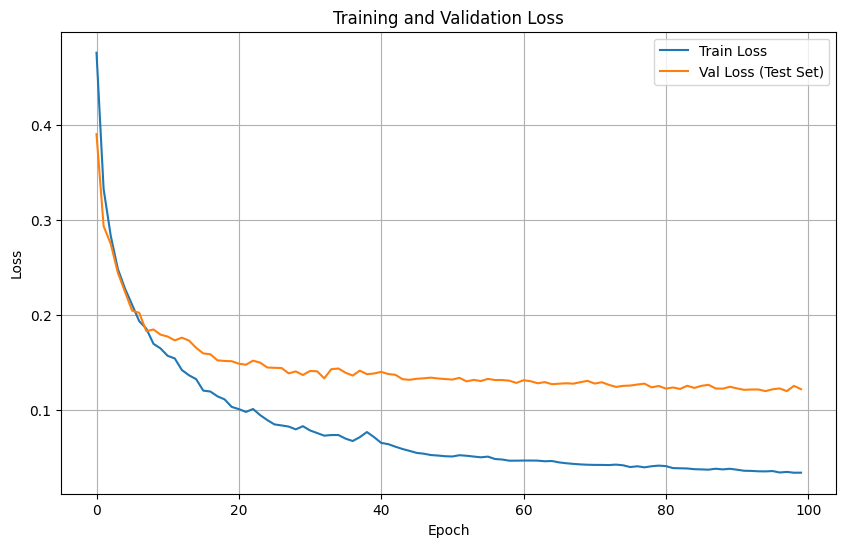

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss (Test Set)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

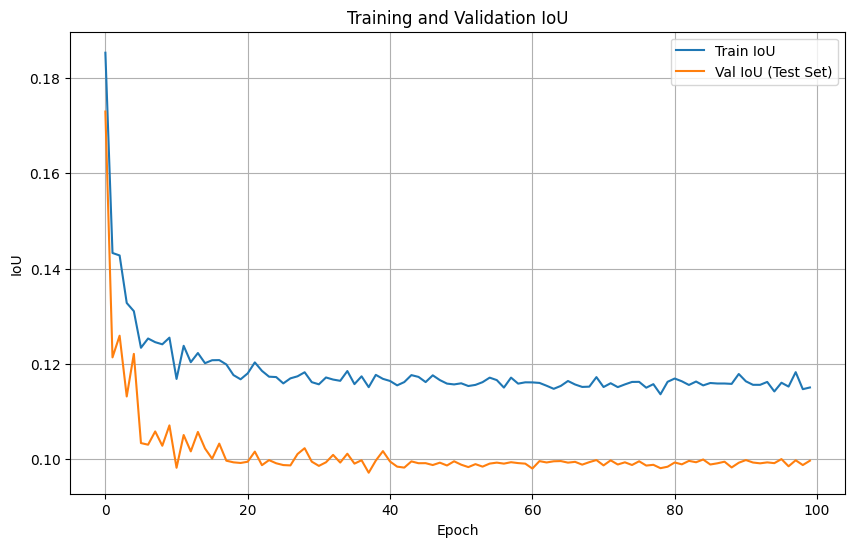

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU (Test Set)')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation Metrics

In [45]:
def evaluate_model(model, loader, device, threshold=0.5):
    model.eval()
    iou_total = 0.0
    precision_total = 0.0
    recall_total = 0.0
    f1_total = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).float().unsqueeze(1)  # [B,1,H,W]

            outputs = model(images)             # logits
            probs = torch.sigmoid(outputs)      # convert logits → probabilities
            pred = (probs > threshold).float()  # binary mask

            intersection = (pred * masks).sum(dim=(1,2,3))
            union = (pred + masks).sum(dim=(1,2,3)) - intersection

            iou = (intersection / (union + 1e-6)).mean().item()

            tp = intersection
            fp = (pred * (1 - masks)).sum(dim=(1,2,3))
            fn = ((1 - pred) * masks).sum(dim=(1,2,3))

            precision = (tp / (tp + fp + 1e-6)).mean().item()
            recall    = (tp / (tp + fn + 1e-6)).mean().item()
            f1        = (2 * precision * recall / (precision + recall + 1e-6))

            iou_total       += iou
            precision_total += precision
            recall_total    += recall
            f1_total        += f1
            num_batches     += 1

    return {
        'IoU':       iou_total / num_batches,
        'Precision': precision_total / num_batches,
        'Recall':    recall_total / num_batches,
        'F1':        f1_total / num_batches
    }

In [46]:
def evaluate_model_better(model, loader, device, threshold=0.5):
    model.eval()
    iou_list, precision_list, recall_list, f1_list = [], [], [], []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).float().unsqueeze(1)  # [B,1,H,W]

            outputs = model(images)             # logits
            probs = torch.sigmoid(outputs)      # convert logits → probabilities
            preds = (probs > threshold).float() # binary masks

            # Loop over batch, compute metrics per image
            for pred, mask in zip(preds, masks):
                intersection = (pred * mask).sum().item()
                union = (pred + mask).sum().item() - intersection

                iou = intersection / (union + 1e-6)

                tp = intersection
                fp = (pred * (1 - mask)).sum().item()
                fn = ((1 - pred) * mask).sum().item()

                precision = tp / (tp + fp + 1e-6)
                recall    = tp / (tp + fn + 1e-6)
                f1        = 2 * precision * recall / (precision + recall + 1e-6)

                iou_list.append(iou)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1)

    return {
        'IoU':       sum(iou_list) / len(iou_list),
        'Precision': sum(precision_list) / len(precision_list),
        'Recall':    sum(recall_list) / len(recall_list),
        'F1':        sum(f1_list) / len(f1_list),
    }


**Why this is better than the one above**

* Each image contributes equally to the final score.

* More robust if dataset has mixed sizes or some images with little/no water.

* Easier to debug: you can print metrics per image if needed.

In [47]:
def find_best_threshold(model, loader, device, thresholds=None):
    if thresholds is None:
        thresholds = [i/10 for i in range(1,10)]  # 0.1 → 0.9

    results = {}
    model.eval()
    with torch.no_grad():
        for t in thresholds:
            iou_total = 0.0
            num_batches = 0
            for images, masks in loader:
                images = images.to(device)
                masks = masks.to(device).float().unsqueeze(1)  # [B,1,H,W]

                outputs = model(images)          # logits
                probs = torch.sigmoid(outputs)   # probs in [0,1]
                preds = (probs > t).float()      # thresholding

                intersection = (preds * masks).sum(dim=(1,2,3))
                union = (preds + masks).sum(dim=(1,2,3)) - intersection
                iou = (intersection / (union + 1e-6)).mean().item()

                iou_total += iou
                num_batches += 1

            results[t] = iou_total / num_batches

    return results

In [48]:
nn_model.load_state_dict(torch.load("best_model_iou.pth", map_location=device))

threshold_results = find_best_threshold(nn_model, test_loader, device)
print(threshold_results)

# Best threshold:
best_t = max(threshold_results, key=threshold_results.get)
print(f"Best threshold = {best_t}, IoU = {threshold_results[best_t]:.4f}")

{0.1: 0.10097937658429146, 0.2: 0.09973376430571079, 0.3: 0.09896289557218552, 0.4: 0.09831303730607033, 0.5: 0.09771597944200039, 0.6: 0.09714329801499844, 0.7: 0.09651011973619461, 0.8: 0.09573127701878548, 0.9: 0.09454679675400257}
Best threshold = 0.1, IoU = 0.1010


**To find the best threshold for the data**

In [ ]:
# @title
# def evaluate_model(model, loader, device, threshold=0.5):
#     model.eval()
#     iou_total = 0.0
#     precision_total = 0.0
#     recall_total = 0.0
#     f1_total = 0.0
#     num_batches = 0
#     with torch.no_grad():
#         for images, masks in loader:
#             images = images.to(device)
#             masks = masks.to(device).float()
#             outputs = model(images)
#             pred = (outputs > threshold).float()
#             intersection = (pred * masks).sum(dim=(1,2,3))
#             union = (pred + masks).sum(dim=(1,2,3)) - intersection
#             iou = (intersection / (union + 1e-6)).mean().item()
#             tp = intersection
#             fp = (pred * (1 - masks)).sum(dim=(1,2,3))
#             fn = ((1 - pred) * masks).sum(dim=(1,2,3))
#             precision = (tp / (tp + fp + 1e-6)).mean().item()
#             recall = (tp / (tp + fn + 1e-6)).mean().item()
#             f1 = (2 * precision * recall / (precision + recall + 1e-6))
#             iou_total += iou
#             precision_total += precision
#             recall_total += recall
#             f1_total += f1
#             num_batches += 1
#     return {
#         'IoU': iou_total / num_batches,
#         'Precision': precision_total / num_batches,
#         'Recall': recall_total / num_batches,
#         'F1': f1_total / num_batches
#     }

In [49]:
metrics = evaluate_model(nn_model, test_loader, device)
print(metrics)

{'IoU': 0.09771597944200039, 'Precision': 0.24195727705955505, 'Recall': 0.21018751710653305, 'F1': 0.22416346257884}


In [50]:
metrics_better = evaluate_model_better(nn_model, test_loader, device)
print(metrics)

{'IoU': 0.09771597944200039, 'Precision': 0.24195727705955505, 'Recall': 0.21018751710653305, 'F1': 0.22416346257884}


## Visualize Predictions

In [55]:
import random

def visualize_prediction_rgb_samples(model, test_pairs, mins, maxs, device, n_samples=1, use_indices=True):
    selected_pairs = random.sample(test_pairs, min(n_samples, len(test_pairs)))
    for img_path, mask_path in selected_pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        if use_indices:
            img = compute_water_indices(img)
        mask = load_mask(mask_path)
        # Create RGB image from bands (Red: 3, Green: 2, Blue: 1)
        rgb_img = img[[3, 2, 1]]  # Select Red, Green, Blue bands
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-6)  # Normalize for display
        img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            pred = model(img_tensor).squeeze().cpu().numpy() > 0.5
        fig, axs = plt.subplots(1, 3, figsize=(12, 5))
        axs[0].imshow(np.transpose(rgb_img, (1, 2, 0)))  # Transpose to (H, W, C) for imshow
        axs[0].set_title('RGB Image')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[2].imshow(pred, cmap='gray')
        axs[2].set_title('Predicted Mask')
        plt.show()

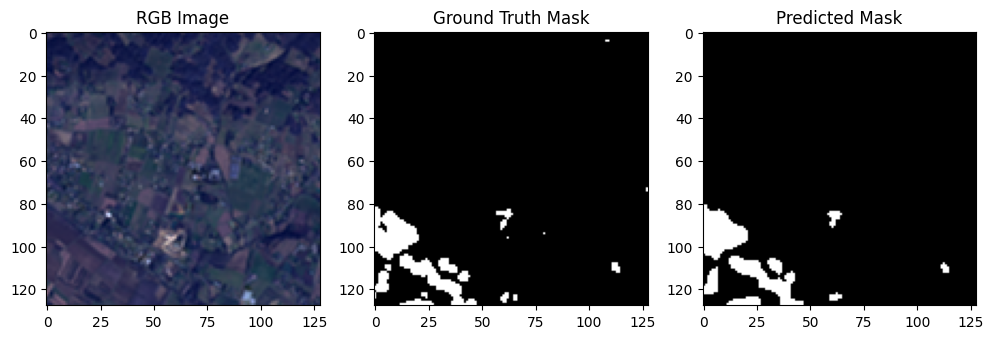

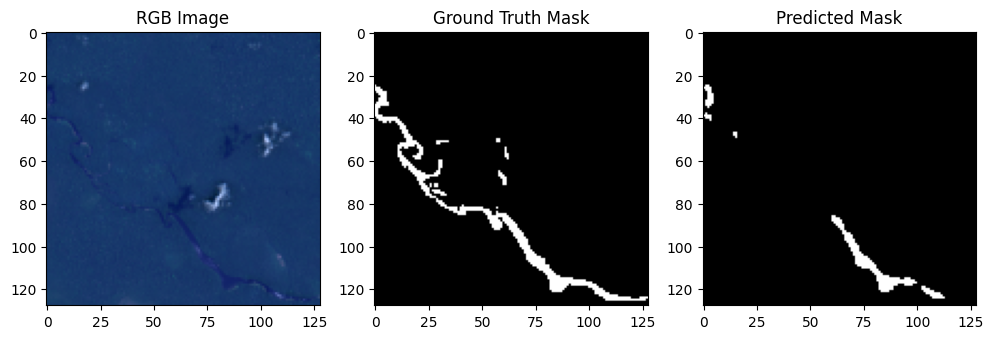

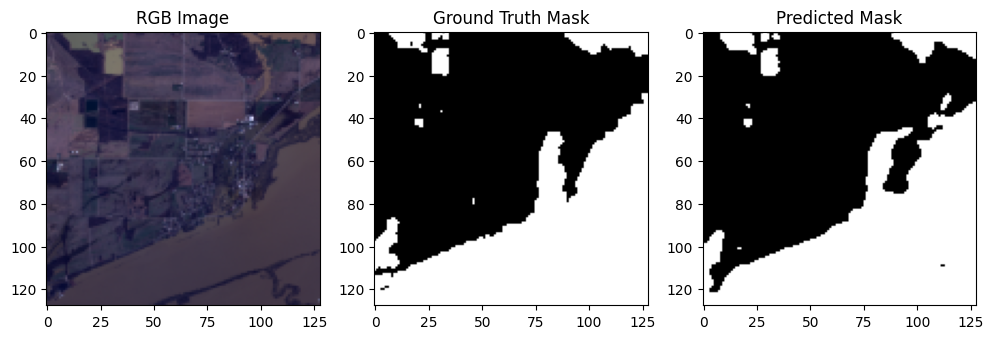

In [56]:
# Call the visualize_prediction_rgb_samples function
visualize_prediction_rgb_samples(nn_model, test_pairs, mins, maxs, device, n_samples=3)

In [61]:
import random
import matplotlib.colors as mcolors

def visualize_prediction_rgb_samples(model, test_image_paths, test_mask_paths, mins, maxs, device, n_samples=1, use_indices=True):
    """
    Visualizes random samples of input images (RGB approximation), ground truth masks,
    and predicted masks from the test set.

    Args:
        model (torch.nn.Module): The trained segmentation model.
        test_image_paths (list): List of image paths for the test set.
        test_mask_paths (list): List of mask paths for the test set.
        mins (np.ndarray): Minimum values for each channel from the training set.
        maxs (np.ndarray): Maximum values for each channel from the training set.
        device (torch.device): The device to run the model on (cuda or cpu).
        n_samples (int): Number of random samples to visualize.
        use_indices (bool): Whether to include computed water indices as channels.
    """
    selected_indices = random.sample(range(len(test_image_paths)), min(n_samples, len(test_image_paths)))

    # Create a colormap for masks: 0 (no water) as black, 1 (water) as blue
    cmap_mask = mcolors.ListedColormap(['black', 'blue'])
    bounds = [0, 0.5, 1]
    norm_mask = mcolors.BoundaryNorm(bounds, cmap_mask.N)

    for idx in selected_indices:
        img_path = test_image_paths[idx]
        mask_path = test_mask_paths[idx]

        # Load, normalize, and potentially add indices to the image
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        if use_indices:
            img = compute_water_indices(img)

        # Load the mask
        mask = load_mask(mask_path)

        # Create RGB image from bands (Red: 3, Green: 2, Blue: 1)
        # Ensure bands exist before selecting
        if img.shape[0] > 3: # Check if there are at least 4 bands (0-indexed 3 is the 4th band)
             rgb_img = img[[3, 2, 1], :, :]  # Select Red, Green, Blue bands
             # Normalize for display
             rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-6)
             rgb_img_display = np.transpose(rgb_img, (1, 2, 0)) # Transpose to (H, W, C) for imshow
        else:
             # If not enough bands for RGB, just show the first band or handle differently
             print(f"Warning: Not enough bands ({img.shape[0]}) to create RGB image for sample {idx}. Showing first band.")
             rgb_img_display = img[0, :, :] # Show first band

        # Prepare image tensor for model prediction
        img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)

        # Get model prediction
        model.eval()
        with torch.no_grad():
            pred = model(img_tensor).squeeze().cpu().numpy() > 0.5

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot Input Image (RGB approximation or first band)
        if rgb_img_display.ndim == 3:
            axs[0].imshow(rgb_img_display)
            axs[0].set_title('RGB Image')
        else:
             axs[0].imshow(rgb_img_display, cmap='gray')
             axs[0].set_title('Input Image (Band 1)')

        axs[0].axis('off')


        # Plot Ground Truth Mask with custom colormap
        axs[1].imshow(mask, cmap=cmap_mask, norm=norm_mask)
        axs[1].set_title('Ground Truth Mask (Blue: Water)')
        axs[1].axis('off')

        # Plot Predicted Mask with custom colormap
        axs[2].imshow(pred, cmap=cmap_mask, norm=norm_mask)
        axs[2].set_title('Predicted Mask (Blue: Water)')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

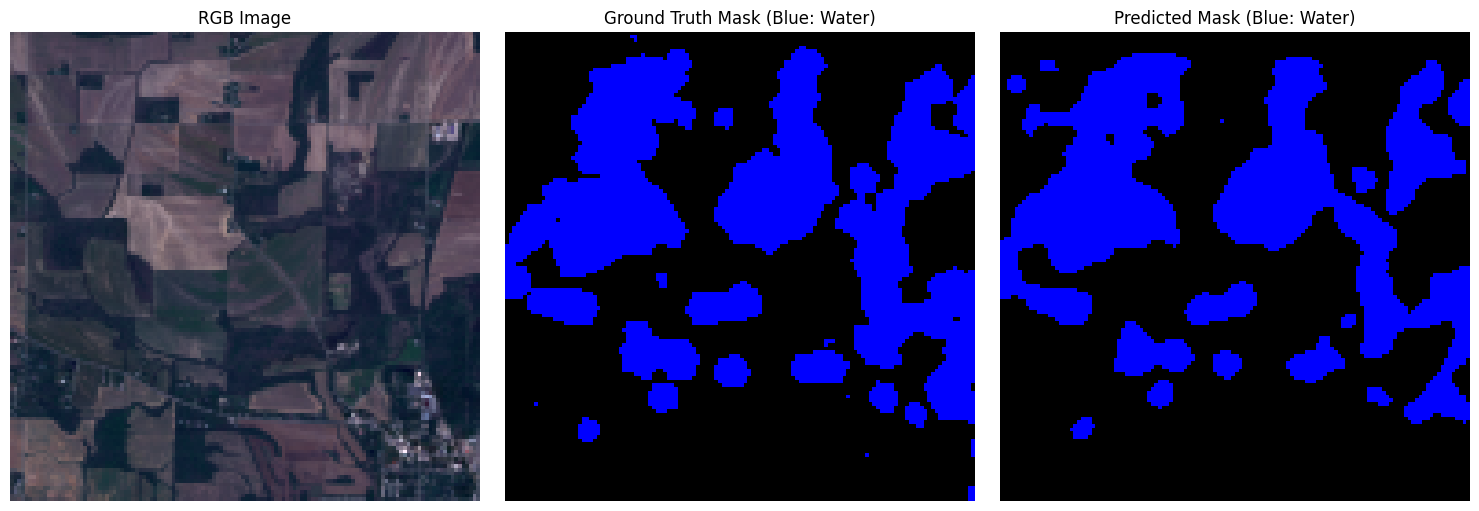

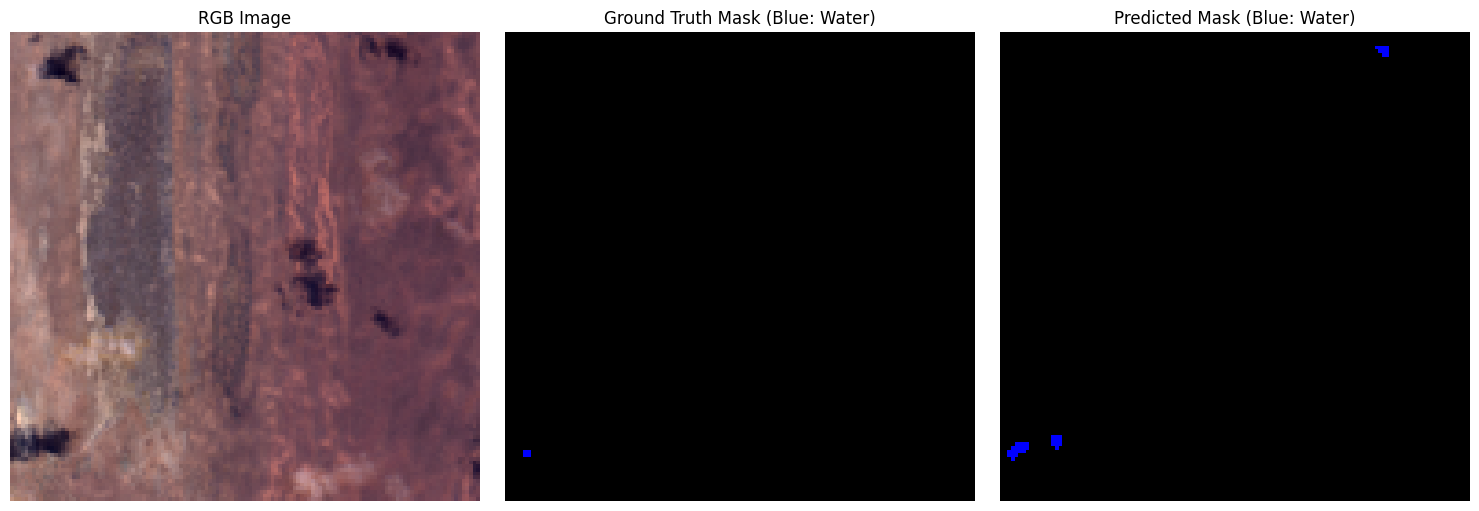

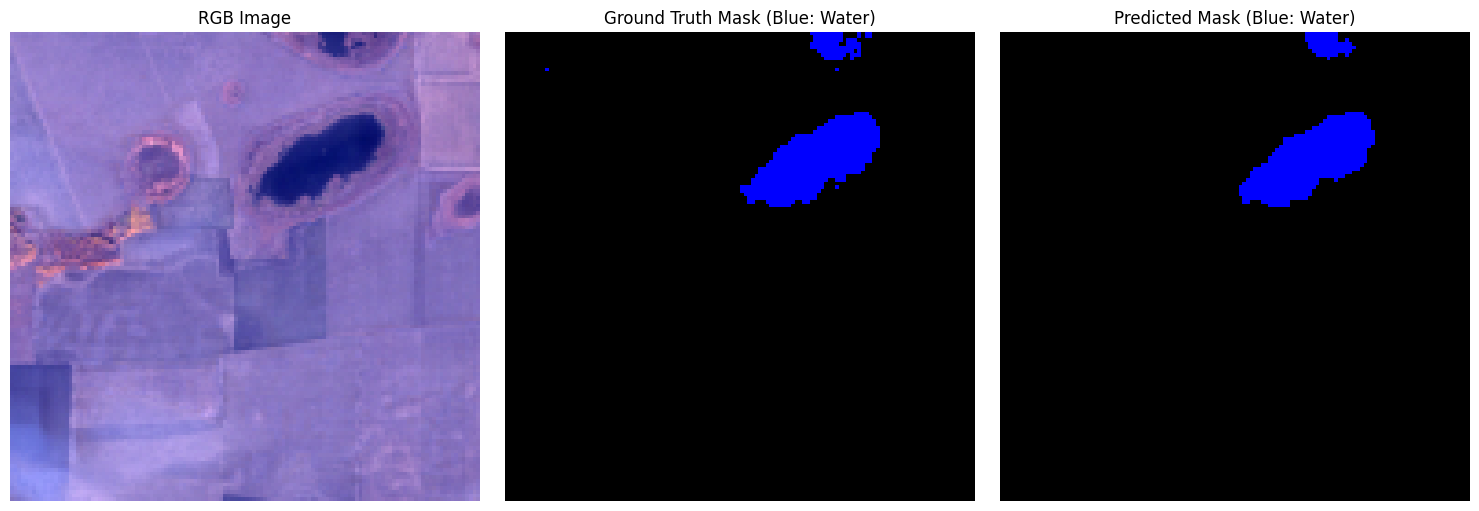

In [62]:
# # Example: Visualize 3 random test samples
test_image_paths = [pair[0] for pair in test_pairs]
test_mask_paths = [pair[1] for pair in test_pairs]
visualize_prediction_rgb_samples(nn_model, test_image_paths, test_mask_paths, mins, maxs, device, n_samples=3)



---

# Deployment using Streamlit and Ngrok

In [57]:
# 1) install dependencies
!pip install -q streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 127.2 MB/s eta 0:00:00


In [ ]:
## for using the token without showing it, delete after running it
# import os
# os.environ["NGROK_AUTH_TOKEN"] = "your-token-here"

In [64]:
from pyngrok import ngrok
ngrok.set_auth_token(os.environ["NGROK_AUTH_TOKEN"])

In [95]:
%%writefile app.py

import streamlit as st
from pyngrok import ngrok
from pathlib import Path
import torch
import numpy as np
import rasterio
import cv2
import os
import shutil


# Change caption color to black
st.markdown(
    """
    <style>
    .stImage caption {
        color: black !important;
        font-weight: 500;
    }
    </style>
    """,
    unsafe_allow_html=True
)


# Assume the model is saved as 'best_model_iou.pth'
best_model_path_iou = 'best_model_iou.pth'  # File to save the best model
best_model_path_loss = 'best_model_val_loss.pth'
# Define paths for saved mins and maxs
mins_path = 'mins.npy'
maxs_path = 'maxs.npy'


# --- Define necessary functions (copying from your notebook) ---

# Function to Load Multispectral Image (assuming you want to use the 12 bands + indices)
def load_image_for_inference(path):
    with rasterio.open(path) as src:
        img = src.read()  # Shape: (bands, height, width)
        img = img.astype(np.float32)
    return img

# Function to Normalize Image (Min-Max Scaling) - Need mins/maxs from training
# For deployment, we'll use the mins/maxs computed during training.
# You'll need to ensure 'mins' and 'maxs' are available or loaded here.
# For this example, I'll assume they are loaded or accessible.
# In a real deployment script, you might save these with your model.
# Let's placeholder them for now, you'll need to replace these with your actual trained mins/maxs
# Example placeholder (replace with your actual values):
# mins = np.array([... 12 values ...])
# maxs = np.array([... 12 values ...])

# Function to Normalize Image (Min-Max Scaling)
# Using placeholder mins/maxs for now
# IMPORTANT: Replace these with the actual mins and maxs computed during training
# You might want to save and load these alongside your model
# try:
#     # Attempt to use the mins and maxs computed in the notebook
#     # This assumes you run the notebook sequentially.
#     # For a standalone app.py, you would need to load these from a file.
#     notebook_mins = mins
#     notebook_maxs = maxs
# except NameError:
#     # If mins/maxs are not defined in the notebook environment, use placeholders or load from file
#     st.error("Mins and Maxs not found. Please ensure they are computed or loaded.")
#     st.stop() # Stop execution if mins/maxs are not available

# Function to Normalize Image (Min-Max Scaling)
def normalize_image_for_inference(img, mins, maxs):
    # Ensure the image has the same number of channels as mins/maxs
    if img.shape[0] != len(mins):
        st.error(f"Image has {img.shape[0]} bands, but mins/maxs have {len(mins)}. Normalization failed.")
        return img # Or raise an error

    normalized_img = np.copy(img) # Avoid modifying the original img array
    for c in range(len(mins)):
         # Handle cases where max-min is zero
        denominator = (maxs[c] - mins[c])
        if denominator == 0:
             normalized_img[c] = 0 # or handle as appropriate, maybe leave as is?
        else:
             normalized_img[c] = (img[c] - mins[c]) / (denominator + 1e-6)
    return normalized_img


# Function to Compute Water Indices
def compute_water_indices_for_inference(img):
    # Channel indices based on diagram (assuming the input img is the 12-band image):
    # 0: Coastal, 1: Blue, 2: Green, 3: Red, 4: NIR, 5: SWIR1, 6: SWIR2, ...
    # Ensure required bands exist (at least Green, NIR, SWIR1, SWIR2 - indices 2, 4, 5, 6)
    if img.shape[0] < 7:
        st.warning(f"Image has only {img.shape[0]} bands. Cannot compute all water indices. Proceeding without indices.")
        return img # Return original image if not enough bands

    green = img[2]
    nir = img[4]
    swir1 = img[5]
    swir2 = img[6]

    # Compute indices, handle division by zero
    ndwi = np.zeros_like(green)
    mndwi = np.zeros_like(green)
    awei = np.zeros_like(green)

    # NDWI
    sum_green_nir = green + nir
    ndwi = np.divide((green - nir), sum_green_nir, out=ndwi, where=(sum_green_nir != 0))

    # MNDWI
    sum_green_swir1 = green + swir1
    mndwi = np.divide((green - swir1), sum_green_swir1, out=mndwi, where=(sum_green_swir1 != 0))

    # AWEI (using the formula from your notebook, which matches AWEI_SH)
    awei = 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)


    indices = np.stack([ndwi, mndwi, awei], axis=0)
    img_with_indices = np.concatenate([img, indices], axis=0)  # Should be (15, H, W) if 12 bands + 3 indices
    return img_with_indices


# Function to Perform Inference
def inference_on_tif(model, tif_path, mins, maxs, device, img_size=128, include_indices=True):
    img = load_image_for_inference(tif_path)

    # Handle potential resizing if image is not img_size x img_size
    if img.shape[1] != img_size or img.shape[2] != img_size:
        st.warning(f"Image size is {img.shape[1]}x{img.shape[2]}. Resizing to {img_size}x{img_size}.")
        # Assuming channel-first (C, H, W)
        resized_img = np.zeros((img.shape[0], img_size, img_size), dtype=img.dtype)
        for c in range(img.shape[0]):
             resized_img[c, :, :] = cv2.resize(img[c, :, :], (img_size, img_size), interpolation=cv2.INTER_AREA)
        img = resized_img

    # Normalize the image using the loaded mins/maxs
    img = normalize_image_for_inference(img, mins, maxs)

    # Compute water indices if required
    if include_indices:
        img = compute_water_indices_for_inference(img)

    # Ensure the image has the correct number of channels for the model
    expected_channels = model_in_channels
    if img.shape[0] != expected_channels:
         st.error(f"Processed image has {img.shape[0]} channels, but model expects {expected_channels}. Cannot run inference.")
         return None # Indicate failure

    # Prepare image tensor
    img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)

    # Perform inference
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)

    # Post-process output
    probs = torch.sigmoid(output)
    pred_mask = (probs.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    return pred_mask


import segmentation_models_pytorch as smp

def get_model(num_channels, classes=1):
    model = smp.Unet(
        encoder_name="resnet34",     # backbone
        encoder_weights="imagenet",  # pretrained weights
        in_channels=num_channels,    # 15 (12 bands + 3 indices)
        classes=classes,
        activation=None              # logits output (apply sigmoid later)
    )
    return model


# --- Load the model and mins/maxs ---
# Ensure the model architecture matches the saved state_dict
# You need the same num_channels used during training (15 if indices were used)
model_in_channels = 15 # Change this if you trained with a different number of channels
try:
    # Assume get_model function is defined in your notebook (or redefine it here if necessary)
    # If get_model is defined in the notebook, ensure that cell is run before this one.
    # For a truly standalone app.py, you would need to define get_model within this script.
    try:
        # Attempt to use get_model from the notebook environment
        model = get_model(num_channels=model_in_channels)
    except NameError:
        st.error("The 'get_model' function is not defined. Please ensure the cell defining 'get_model' has been run, or define it within app.py.")
        st.stop()


    model.load_state_dict(torch.load(best_model_path_iou, map_location='cpu'))
    model.eval()
    st.success(f"Model loaded successfully from {best_model_path_iou}")

    # Load mins and maxs
    mins = np.load(mins_path)
    maxs = np.load(maxs_path)
    st.success("Mins and maxs loaded successfully.")

except FileNotFoundError as e:
    st.error(f"Required file not found: {e}. Please ensure {best_model_path_iou}, {mins_path}, and {maxs_path} exist.")
    st.stop()
except Exception as e:
    st.error(f"Error during setup: {e}")
    st.stop()


# --- Streamlit App ---
st.title("Satellite Image Water Segmentation")

uploaded_file = st.file_uploader("Upload a multispectral .tif image", type=['tif', 'tiff'])

if uploaded_file is not None:
    # Save the uploaded file temporarily
    temp_dir = "temp_uploads"
    os.makedirs(temp_dir, exist_ok=True)
    temp_path = os.path.join(temp_dir, uploaded_file.name)
    with open(temp_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    st.write("Processing image...")

    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Perform inference
    # Pass the loaded mins and maxs to the inference function
    predicted_mask = inference_on_tif(model, temp_path, mins, maxs, device, img_size=128, include_indices=True)

    if predicted_mask is not None:
        st.write("Inference complete.")

        # Display Original RGB (Approximation)
        try:
             # Load the original 12-band image again just for RGB display
            original_img_12_bands = load_image_for_inference(temp_path)
            # Normalize for display (using the notebook mins/maxs if available, or global min/max of RGB bands)
            # Simple global min/max for display purposes of RGB
            if original_img_12_bands.shape[0] > 3:
                rgb_display_bands = original_img_12_bands[[3, 2, 1], :, :] # Red, Green, Blue bands
                # Normalize for display
                rgb_display_bands = (rgb_display_bands - rgb_display_bands.min()) / (rgb_display_bands.max() - rgb_display_bands.min() + 1e-6)
                rgb_display = np.transpose(rgb_display_bands, (1, 2, 0))
                st.subheader("Original Image (RGB Approximation)")
                # st.image(rgb_display, caption="RGB Image", use_container_width=True)
                st.image(rgb_display, caption="RGB Image", width=400)
            else:
                 st.warning("Could not create RGB approximation (less than 4 bands in original image).")

        except Exception as e:
             st.warning(f"Could not display RGB approximation: {e}")


        # Display Predicted Mask (make it blue for water)
        st.subheader("Predicted Water Mask")
        # Create a simple blue mask visualization
        # Water pixels (1) will be blue, non-water (0) will be black
        colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8) # H, W, C (RGB)
        colored_mask[predicted_mask == 1] = [0, 0, 255] # Blue color for water

        # st.image(colored_mask, caption="Predicted Water Mask (Blue)", use_container_width=True)
        st.image(colored_mask, caption="Predicted Water Mask (Blue)", width=400)  # adjust width as needed


    # If you want both images in one row (RGB + Mask), use Streamlit columns:
    st.subheader("Results Side by Side:")

    col1, col2 = st.columns(2)
    with col1:
        st.image(rgb_display, caption="RGB Image", width=350)
    with col2:
        st.image(colored_mask, caption="Predicted Water Mask (Blue)", width=350)


    # Clean up the temporary file
    os.remove(temp_path)
    os.rmdir(temp_dir)

    # to make sure it deletes temp files
    shutil.rmtree(temp_dir, ignore_errors=True)

# --- Ngrok Tunnel (Optional for public access) ---
# You only need to run the ngrok part if you want to expose your app publicly.
# For running locally in Colab, the local Streamlit URL is often sufficient.
# To use ngrok, you need to install it (`!pip install pyngrok`) and potentially set an auth token.

# Check if ngrok is already running or connect
try:
    public_url = ngrok.connect(8501)
    st.write("Ngrok Tunnel:")
    st.write(public_url)
except Exception as e:
    st.warning(f"Could not establish Ngrok tunnel: {e}. Streamlit app might only be accessible locally.")
    st.info("To use Ngrok, you might need to install it (`!pip install pyngrok`) and potentially set an auth token (`ngrok.set_auth_token('YOUR_AUTH_TOKEN')`).")

# --- Instructions to run Streamlit ---
st.sidebar.markdown("## How to Run")
st.sidebar.markdown("1. Upload an Image by selecting Browse Files.")
st.sidebar.markdown("2. the multispectral image you uploaded will be shown in RGB Format.")
st.sidebar.markdown("3. The model will visualize a water mask segmenting the water body in the photo you uploaded.")
# If using ngrok, the public URL will also be printed.

Overwriting app.py


In [96]:
import os, time
from pyngrok import ngrok
from IPython.display import display, HTML

APP_PATH = "app.py"
PORT = 8501

# Run streamlit headless in background
streamlit_cmd = f"streamlit run {APP_PATH} --server.port {PORT} --server.headless true &"
print("Starting Streamlit with:", streamlit_cmd)
os.system(streamlit_cmd)

# Wait for boot
time.sleep(3)

# Create Ngrok tunnel
public_tunnel = ngrok.connect(PORT, bind_tls=True)
print("ngrok tunnel created:", public_tunnel.public_url)

# Clickable link
display(HTML(f'<a href="{public_tunnel.public_url}" target="_blank">Open Streamlit app (ngrok)</a>'))

Starting Streamlit with: streamlit run app.py --server.port 8501 --server.headless true &
ngrok tunnel created: https://fe940674466d.ngrok-free.app


## To Close the site

In [94]:
from pyngrok import ngrok

# Kill all ngrok tunnels
ngrok.kill()

#